In [1]:
import pydot
import tensorflow as tf
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
# small library for seeing the progress of loops.
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions



In [3]:
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions



In [4]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab


In [7]:
def save_description(description,filename):
    lines=list()
    for img,capt in description.items():
        for c in capt:
            lines.append(img+'\t'+c)
    data='\n'.join(lines)
    file=open(filename,'w')
    file.write(data)
    file.close()

In [8]:
dataset_images='Flickr8k_Dataset/Flicker8k_Dataset'
dataset_text='D:\project_new\image_caption\Flickr8k_text\Flickr8k.token.txt'

In [9]:
print(dataset_text)

D:\project_new\image_caption\Flickr8k_text\Flickr8k.token.txt


In [10]:
descriptions=all_img_captions(dataset_text)

In [11]:
descriptions

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

In [12]:
len(descriptions)

8092

In [13]:
clean_descriptions=cleaning_text(descriptions)

In [14]:
vocabulary=text_vocabulary(clean_descriptions)
vocabulary

{'filled',
 'shed',
 'ceramic',
 'spanish',
 'teddy',
 'wrangle',
 'fastest',
 'pours',
 'snowcapped',
 'eyese',
 'crazily',
 'erupts',
 'toddles',
 'allwhite',
 'stroke',
 'restrain',
 'hilltop',
 'risen',
 'pf',
 'cycling',
 'looptheloop',
 'refrigerator',
 'barn',
 'kerry',
 'perspective',
 'scraping',
 'slides',
 'earnhardt',
 'boods',
 'pee',
 'railway',
 'disguise',
 'vest',
 'panting',
 'colored',
 'peeing',
 'depth',
 'almostdried',
 'hitting',
 'dimlight',
 'messy',
 'whites',
 'advertisements',
 'grounded',
 'flickr',
 'battons',
 'weather',
 'precariously',
 'bushels',
 'kite',
 'shite',
 'zippered',
 'relatively',
 'trots',
 'wodden',
 'modern',
 'wrestled',
 'china',
 'seesaw',
 'ther',
 'scored',
 'extinguish',
 'swerves',
 'smock',
 'yankees',
 'takeing',
 'gazing',
 'customer',
 'blur',
 'mingle',
 'desertlike',
 'rappels',
 'container',
 'forward',
 'hurdlejumper',
 'badly',
 'ashtray',
 'perpendicular',
 'board',
 'lawnmower',
 'min',
 'fortess',
 'snowbank',
 'khakis

In [15]:
len(vocabulary)

8763

In [16]:
save_description(clean_descriptions,'descriptions.txt')

In [17]:
features=load(open('features.p','rb'))
features

{'1000268201_693b08cb0e.jpg': array([[0.47339684, 0.01732643, 0.07333998, ..., 0.0855904 , 0.02102295,
         0.23766544]], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([[0.00158211, 0.11113487, 0.00037397, ..., 0.26503602, 0.35279822,
         0.05871649]], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([[0.        , 0.02488983, 0.01554059, ..., 0.        , 0.        ,
         0.10192626]], dtype=float32),
 '1003163366_44323f5815.jpg': array([[0.14568879, 0.00272414, 0.27776527, ..., 0.17018232, 0.11957303,
         0.09414067]], dtype=float32),
 '1007129816_e794419615.jpg': array([[0.        , 0.12443952, 0.7391621 , ..., 0.00390435, 0.00997149,
         0.5017237 ]], dtype=float32),
 '1007320043_627395c3d8.jpg': array([[0.04136695, 0.        , 0.0127447 , ..., 0.00944686, 0.64201635,
         0.04792112]], dtype=float32),
 '1009434119_febe49276a.jpg': array([[0.        , 0.        , 0.02624729, ..., 0.30528584, 0.23091821,
         0.14191067]], dtype=float32),
 '1012

In [18]:
def load_photos(filename):
    file=load_doc(filename)
    photos=file.split("\n")[:-1]
    return photos

def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [19]:
filename = "D:\project_new\image_caption\Flickr8k_text\Flickr_8k.trainImages.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [20]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


In [21]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [22]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [23]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield (input_image, input_sequence), output_word
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [24]:
gen = data_generator(train_descriptions, train_features, tokenizer, max_length)
sample = next(gen)
print("Sample:", sample)
print("Feature Shape:", sample[0][0].shape)  # Image feature vector
print("Input Sequence Shape:", sample[0][1].shape)  # Input sequence
print("Output Shape:", sample[1].shape)  # Output word (one-hot encoded)


Sample: ((array([[0.47339684, 0.01732643, 0.07333998, ..., 0.0855904 , 0.02102295,
        0.23766544],
       [0.47339684, 0.01732643, 0.07333998, ..., 0.0855904 , 0.02102295,
        0.23766544],
       [0.47339684, 0.01732643, 0.07333998, ..., 0.0855904 , 0.02102295,
        0.23766544],
       ...,
       [0.47339684, 0.01732643, 0.07333998, ..., 0.0855904 , 0.02102295,
        0.23766544],
       [0.47339684, 0.01732643, 0.07333998, ..., 0.0855904 , 0.02102295,
        0.23766544],
       [0.47339684, 0.01732643, 0.07333998, ..., 0.0855904 , 0.02102295,
        0.23766544]], dtype=float32), array([[   0,    0,    0, ...,    0,    0,    2],
       [   0,    0,    0, ...,    0,    2,   42],
       [   0,    0,    0, ...,    2,   42,    3],
       ...,
       [   0,    0,    0, ...,  169,  313,   64],
       [   0,    0,    0, ...,  313,   64,  195],
       [   0,    0,    0, ...,   64,  195, 2913]])), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
      

In [25]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model


In [30]:
from keras.callbacks import ModelCheckpoint
import os

# Print dataset details
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

# Define the model
model = define_model(vocab_size, max_length)

# Create 'models' directory if it doesn't exist
if not os.path.exists("models"):
    os.mkdir("models")

# Configure ModelCheckpoint
checkpoint = ModelCheckpoint(
    "models/model_{epoch:02d}.keras",  # Use .keras extension
    save_best_only=False,  # Save all epochs
    verbose=1
)

# Train the model
model.fit(
    data_generator(train_descriptions, train_features, tokenizer, max_length),
    epochs=10,
    steps_per_epoch=steps,
    callbacks=[checkpoint]
)

# Explicitly save the final model
model.save("models/final_model.keras")
print("Final model saved in .keras format.")


Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 32, 256)   │  1,939,712 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 2048)      │          0 │ input_layer_10[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 256)   │          0 │ embedding_5[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 32)        │          0 │ input_layer_11[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    524,544 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 256)       │    525,312 │ dropout_11[0][0], │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256)       │          0 │ dense_15[0][0],   │
│                     │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │     65,792 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 7577)      │  1,947,289 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,002,649 (19.08 MB)

 Trainable params: 5,002,649 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 4.9780
Epoch 1: saving model to models/model_01.keras
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1121s 186ms/step - loss: 4.9779
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 3.7111
Epoch 2: saving model to models/model_02.keras
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1026s 171ms/step - loss: 3.7111
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 3.3775
Epoch 3: saving model to models/model_03.keras
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1064s 177ms/step - loss: 3.3775
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.1938
Epoch 4: saving model to models/model_04.keras
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1097s 183ms/step - loss: 3.1938
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - loss: 3.0653
Epoch 5: saving model to models/model_05.keras
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 2723s 454ms/step - loss: 3.0653
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 2.9720
Epoch 6: saving mod

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Generated Description:

start dog is running through the grass end


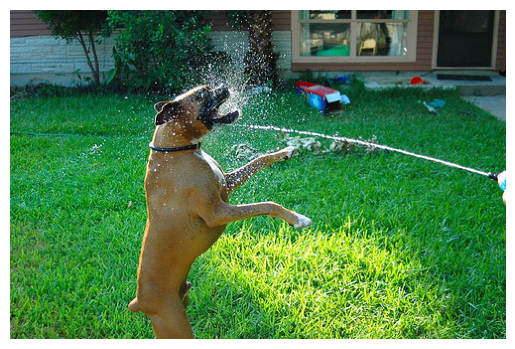

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.applications.xception import Xception
from keras.preprocessing.sequence import pad_sequences
from pickle import load

# Function to extract features using the Xception model
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except Exception as e:
        print(f"ERROR: Couldn't open image! {e}")
        return None
    image = image.resize((299, 299))
    image = np.array(image)
    # Convert 4-channel images to 3-channel
    if image.shape[-1] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5 - 1.0  # Preprocessing for Xception
    feature = model.predict(image)
    return feature

# Function to map an integer to a word using the tokenizer
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate a description for the image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

# Input image path
img_path = '44856031_0d82c2c7d1.jpg'

# Parameters
max_length = 32

# Load the tokenizer and models
tokenizer = load(open("tokenizer.p", "rb"))
model = load_model('D:\project_new\image_caption\models\model_10.keras')
xception_model = Xception(include_top=False, pooling="avg")

# Process the image and generate a description
photo = extract_features(img_path, xception_model)
if photo is not None:
    img = Image.open(img_path)
    description = generate_desc(model, tokenizer, photo, max_length)
    print("\nGenerated Description:\n")
    print(description)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print("Failed to process the image.")


In [28]:
for key, desc_list in list(descriptions.items())[:5]:  # Visualize for 5 images
    yhat = generate_desc(model, tokenizer, features[key], max_length)
    print("Predicted:", yhat)
    print("Actual:", desc_list[0])  # First actual caption


Predicted: start two girls are sitting on the bed with his arms around each other end
Actual: child in pink dress is climbing up set of stairs in an entry way
Predicted: start dog is running through the grass end
Actual: black dog and spotted dog are fighting
Predicted: start man in red shirt is sitting on bench end
Actual: little girl covered in paint sits in front of painted rainbow with her hands in bowl
Predicted: start dog is running through the grass end
Actual: man lays on bench while his dog sits by him
Predicted: start man in black shirt and black shirt is standing in front of building end
Actual: man in an orange hat starring at something


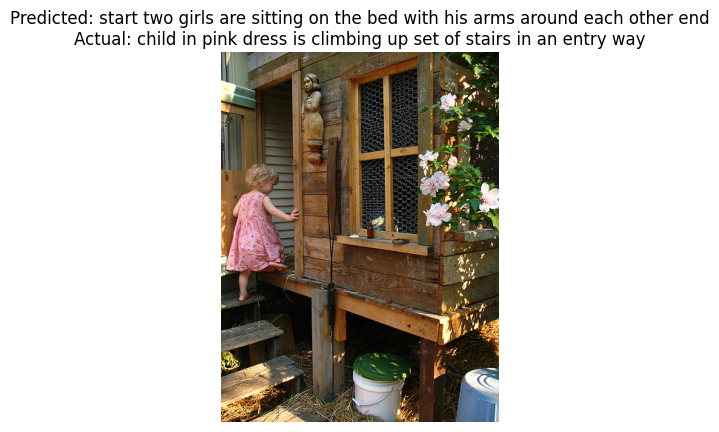

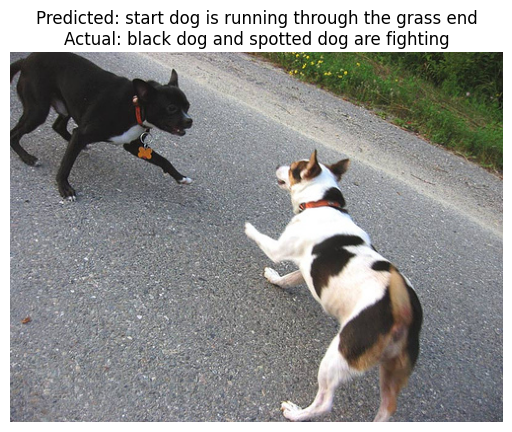

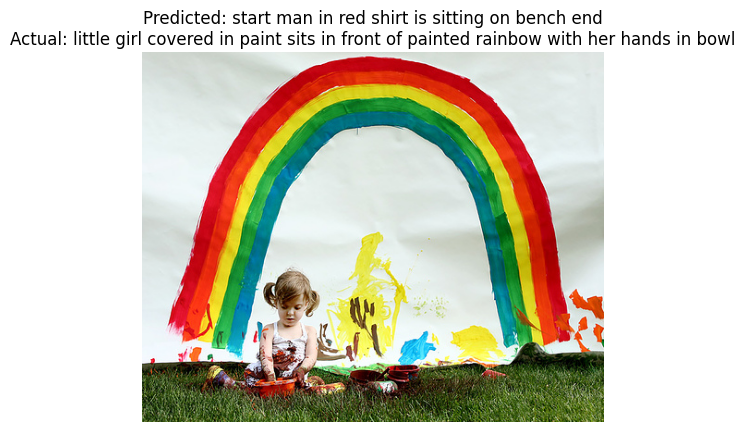

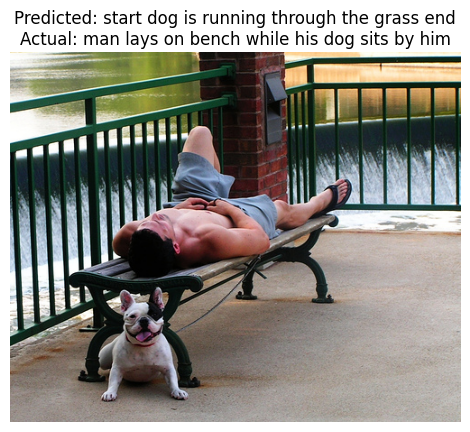

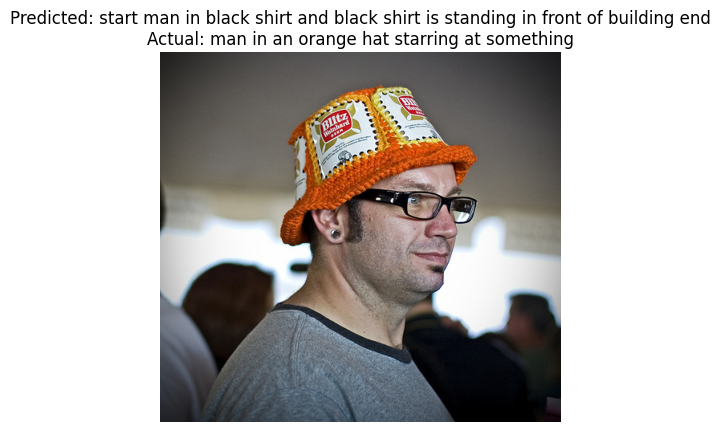

In [30]:
import matplotlib.pyplot as plt
from PIL import Image

for key, desc_list in list(descriptions.items())[:5]:
    image_path = f"Flickr8k_Dataset\Flicker8k_Dataset/{key}"
    img = Image.open(image_path)
    yhat = generate_desc(model, tokenizer, features[key], max_length)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {yhat}\nActual: {desc_list[0]}")
    plt.show()
